# GENERATION OF SEVERAL SUPPLEMENTARY TABLES + CLEANED-UP SOURCE DATA

load modules:

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
import random

sys.path.append("../../scripts/")
import reference_based_harmonizing
import utils

In [4]:
%load_ext lab_black

set paths:

In [5]:
path_hlca_core = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
path_hlca_core_clean_out = (
    "../../data/HLCA_core_h5ads/clean_objects_to_share/HLCA_core_v1.1_to_share.h5ad"
)
path_hlca_ext = "../../data/HLCA_extended/HLCA_extended/HLCA_extended_full_object.h5ad"
path_hlca_ext_clean_out = (
    "../../data/HLCA_extended/clean_objects_to_share/HLCA_full_v1.1_to_share.h5ad"
)
path_cell_label_harmonization = "../../supporting_files/metadata_harmonization/HLCA_cell_type_reference_mapping_20221007.csv"
path_celltype_mapping_to_ontology = "../../supporting_files/metadata_harmonization/cell_type_mapping_to_cellontology.csv"
path_manual_anns_in = "../../supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv"
dir_cov_mod_results_in = "../../results/covariate_modeling/output/"
dir_supp_tables_out = "../../results/suppl_tables/"

load data:

In [4]:
core = sc.read_h5ad(path_hlca_core)

In [5]:
core

AnnData object with n_obs × n_vars = 584944 × 28527
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', 

In [4]:
ext = sc.read_h5ad(path_hlca_ext)

In [5]:
ext.shape

(2382658, 59586)

In [6]:
ext

AnnData object with n_obs × n_vars = 2382658 × 59586
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts',

In [7]:
cell_type_to_ontology = pd.read_csv(path_celltype_mapping_to_ontology, index_col=0)

## DATASET TABLE: 

creates part of the dataset info from supplementary table

In [6]:
def get_set_as_str(x):
    """Function to extract string of the set of values from a dataframe column"""
    x_set = x.unique()
    x_set_str_list = [str(i) for i in x_set]
    x_set_str = ", ".join(x_set_str_list)
    return x_set_str

In [7]:
dataset_overview = ext.obs.groupby("study").agg(
    n_datasets=("dataset", "nunique"),
    dataset_names=("dataset", get_set_as_str),
    core_or_extension=("core_or_extension", get_set_as_str),
    lung_condition=("condition", get_set_as_str),
    n_subjects=("subject_ID", "nunique"),
    n_samples=("sample", "nunique"),
    n_cells=("study", "count"),
    cells_or_nuclei=("cells_or_nuclei", get_set_as_str),
    single_cell_platform=("single_cell_platform", get_set_as_str),
    tissue_sampling_type=("sample_type", get_set_as_str),
)

In [8]:
dataset_overview["in_core"] = [
    "core" in c_or_e for c_or_e in dataset_overview.core_or_extension
]

In [9]:
dataset_overview.sort_values(
    by=["in_core", "study"], ascending=[False, True], inplace=True
)

## SAMPLE TABLE

In [10]:
sample_overview = (
    ext.obs.groupby("sample")
    .agg(
        HLCA_core_or_extension=("core_or_extension", "first"),
        dataset=("dataset", "first"),
        study=("study", "first"),
        n_cells=("sample", "count"),
        subject_ID=("subject_ID", "first"),
        age=("age", "first"),
        sex=("sex", "first"),
        lung_condition=("condition", "first"),
        cells_or_nuclei=("cells_or_nuclei", "first"),
        single_cell_platform=("single_cell_platform", "first"),
        tissue_sampling_type=("sample_type", "first"),
        tissue_dissociation_protocol=("tissue_dissociation_protocol", "first"),
        ancestry=("ancestry", "first"),
        mixed_ancestry=("mixed_ancestry", "first"),
        smoking_status=("smoking_status", "first"),
        BMI=("BMI", "first"),
        cause_of_death=("cause_of_death", "first"),
        sequencing_platform=("sequencing_platform", "first"),
        cell_ranger_version=("cell_ranger_version", "first"),
        fresh_or_frozen=("fresh_or_frozen", "first"),
        anatomical_region_level_1=("anatomical_region_level_1", "first"),
        anatomical_region_level_2=("anatomical_region_level_2", "first"),
        anatomical_region_level_3=("anatomical_region_level_3", "first"),
    )
    .sort_values(by=["HLCA_core_or_extension", "study", "dataset", "subject_ID"])
)

sanity check: check if any sample has multiple values for any of these covariates (should not be the case):

In [11]:
agg_style = "nunique"
sample_unique_covs = ext.obs.groupby("sample").agg(
    {
        var: agg_style
        for var in [
            "core_or_extension",
            "dataset",
            "study",
            "sample",
            "subject_ID",
            "age",
            "sex",
            "condition",
            "cells_or_nuclei",
            "single_cell_platform",
            "sample_type",
            "tissue_dissociation_protocol",
            "ancestry",
            "mixed_ancestry",
            "smoking_status",
            "BMI",
            "cause_of_death",
            "sequencing_platform",
            "cell_ranger_version",
            "fresh_or_frozen",
            "anatomical_region_level_1",
            "anatomical_region_level_2",
            "anatomical_region_level_3",
        ]
    }
)

This should be 0:

In [12]:
(sample_unique_covs > 1).sum().sum()

0

for anatomical region, remove forward-propagated labels:

In [13]:
for lev in range(1, 4):
    cov = f"anatomical_region_level_{lev}"
    mapping = {loc: loc for loc in sample_overview[cov].unique()}
    for key, value in mapping.items():
        if not pd.isnull(key):
            if key[:2] in ["1_", "2_"]:
                mapping[key] = np.nan
    sample_overview[cov] = sample_overview[cov].map(mapping)

put "v" before cell ranger version, to prevent conversion to dates in excel:

In [14]:
cell_ranger_cleaner = {
    v: f"v.{v}" for v in sample_overview.cell_ranger_version.unique()
}
cell_ranger_cleaner["nan"] = "nan"
sample_overview.cell_ranger_version = sample_overview.cell_ranger_version.map(
    cell_ranger_cleaner
)

## Cell type reference mapping:

In [15]:
harmonizing_df = reference_based_harmonizing.load_harmonizing_table(
    path_cell_label_harmonization
)
# consensus_df = reference_based_harmonizing.create_consensus_table(harmonizing_df)

remove columns after first "unnamed" column:

In [16]:
last_column = np.where(harmonizing_df.columns.str.startswith("Unnamed"))[0][0]

In [17]:
harmonizing_df = harmonizing_df.iloc[:, :last_column]

In [18]:
harmonizing_df.dropna(axis=0, how="all", inplace=True)
harmonizing_df.dropna(axis=1, how="all", inplace=True)

In [19]:
harmonizing_df

,Level_1,Level_2,Level_3,Level_4,Level_5,Banovich_Kropski_2020,Barbry_Leroy_2020,Jain_Misharin_2021,Krasnow_2020,Meyer_2019,...,Seibold_2020,Teichmann_Meyer_2019,Thienpont_2018,Kaminski_2020,Banovich_Kropski_2020_disease,Misharin_Budinger_2018_disease,Eils_2020,Sheppard_2020,Duong_lungMAP_unpubl,Sun_2020
0,Epithelial,None,None,None,None,None,None,None,None,None,...,None,None,Epithelial,None,Proliferating Epithelial Cells,Proliferating epithelial,None,Epithelial,None,None
1,None,Airway epithelium,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,None,None,Basal,None,None,Basal,None,None,Basal,None,...,None,None,None,Basal,Basal,KRT5 Basal cells,None,None,Basal,basal cells
3,None,None,Basal,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,None,None,Basal,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,Proliferating cells,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
283,Unknown,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,Mast/Basal,unclassified
284,Cancer,None,None,None,None,None,None,None,None,None,...,None,None,Cancer,None,None,None,None,None,None,None
285,Unicorns and artifacts,None,None,None,None,AT2 - low quality,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## Manual annotations, hierarchy:

In [15]:
manual_ann_hierarchy = pd.read_csv(path_manual_anns_in, index_col=0)

In [16]:
manual_ann_hierarchy.drop(columns=["ordering", "colors"], inplace=True)

In [17]:
manual_ann_hierarchy.columns = [
    f"Level {lev} annotation (n cells, % of cells)" for lev in range(1, 6)
]

In [18]:
ct_perc_per_lev = dict()
ct_n_per_lev = dict()
for lev in range(1, 6):
    ct_n = core.obs[f"ann_level_{lev}"].value_counts()
    ct_perc = round(ct_n / core.n_obs * 100, 1)
    ct_perc_per_lev[lev] = ct_perc
    ct_n_per_lev[lev] = ct_n
ct_n_per_lev["finest"] = core.obs.manual_ann.value_counts()
ct_perc_per_lev["finest"] = round(
    core.obs.manual_ann.value_counts() / core.n_obs * 100, 1
)

In [21]:
new_index = list()
for ct in manual_ann_hierarchy.index:
    new_index.append(
        f"{ct} (n={ct_n_per_lev['finest'][ct]}, {ct_perc_per_lev['finest'][ct]}%)"
    )
manual_ann_hierarchy.index = new_index

In [22]:
for lev in range(1, 6):
    new_values_uncleaned = [
        f"{ct} (n={ct_n_per_lev[lev][ct]}, {ct_perc_per_lev[lev][ct]}%)"
        for ct in manual_ann_hierarchy[f"Level {lev} annotation (n cells, % of cells)"]
    ]
    new_values = list()
    for ct in new_values_uncleaned:
        if ct[:2] in ["1_", "2_", "3_", "4_"]:
            new_values.append(np.nan)
        else:
            new_values.append(ct)
    manual_ann_hierarchy[f"Level {lev} annotation (n cells, % of cells)"] = new_values

In [24]:
manual_ann_hierarchy.index.name = "Finest annotation (n cells, % of cells)"

In [25]:
manual_ann_hierarchy

,"Level 1 annotation (n cells, % of cells)","Level 2 annotation (n cells, % of cells)","Level 3 annotation (n cells, % of cells)","Level 4 annotation (n cells, % of cells)","Level 5 annotation (n cells, % of cells)"
"Finest annotation (n cells, % of cells)",,,,,
"Basal resting (n=38955, 6.7%)","Epithelial (n=282065, 48.2%)","Airway epithelium (n=207023, 35.4%)","Basal (n=84713, 14.5%)","Basal resting (n=38955, 6.7%)",NaN
"Suprabasal (n=41158, 7.0%)","Epithelial (n=282065, 48.2%)","Airway epithelium (n=207023, 35.4%)","Basal (n=84713, 14.5%)","Suprabasal (n=41158, 7.0%)",NaN
"Hillock-like (n=4600, 0.8%)","Epithelial (n=282065, 48.2%)","Airway epithelium (n=207023, 35.4%)","Basal (n=84713, 14.5%)","Hillock-like (n=4600, 0.8%)",NaN
"Deuterosomal (n=1004, 0.2%)","Epithelial (n=282065, 48.2%)","Airway epithelium (n=207023, 35.4%)","Multiciliated lineage (n=41098, 7.0%)","Deuterosomal (n=1004, 0.2%)",NaN
"Multiciliated (nasal) (n=4869, 0.8%)","Epithelial (n=282065, 48.2%)","Airway epithelium (n=207023, 35.4%)","Multiciliated lineage (n=41098, 7.0%)","Multiciliated (n=40094, 6.9%)","Multiciliated (nasal) (n=4869, 0.8%)"
...,...,...,...,...,...
"Monocyte-derived Mph (n=28223, 4.8%)","Immune (n=229496, 39.2%)","Myeloid (n=155315, 26.6%)","Macrophages (n=111844, 19.1%)","Interstitial macrophages (n=33028, 5.6%)","Monocyte-derived Mph (n=28223, 4.8%)"
"Interstitial Mph perivascular (n=4805, 0.8%)","Immune (n=229496, 39.2%)","Myeloid (n=155315, 26.6%)","Macrophages (n=111844, 19.1%)","Interstitial macrophages (n=33028, 5.6%)","Interstitial Mph perivascular (n=4805, 0.8%)"
"Classical monocytes (n=17695, 3.0%)","Immune (n=229496, 39.2%)","Myeloid (n=155315, 26.6%)","Monocytes (n=26529, 4.5%)","Classical monocytes (n=17695, 3.0%)",NaN


## Covariate modeling, gene results:

Here we are just renaming the files and storing them in the SuppT folder

In [28]:
# cts = os.listdir(dir_cov_mod_results_in)

In [29]:
# ct_results_gene = dict()

In [30]:
# for ct in cts:
#     ct_results_gene[ct] = pd.read_csv(
#         os.path.join(dir_cov_mod_results_in, ct, "mm_output_padj.csv"), index_col=0
#     )

## "Source data": the HLCA core

prepare:

In [7]:
obs_cols_to_keep = [
    "BMI",
    "age",
    "age_range",
    "anatomical_region_ccf_score",
    "anatomical_region_level_1",
    "anatomical_region_level_2",
    "anatomical_region_level_3",
    "ancestry",
    "ann_level_1_clean",
    "ann_level_2_clean",
    "ann_level_3_clean",
    "ann_level_4_clean",
    "ann_level_5_clean",
    "cause_of_death",
    "condition",
    "dataset",
    "entropy_dataset_leiden_3",
    "entropy_original_ann_level_1_leiden_3",
    "entropy_original_ann_level_2_clean_leiden_3",
    "entropy_original_ann_level_3_clean_leiden_3",
    "entropy_subject_ID_leiden_3",
    "fresh_or_frozen",
    "leiden_1",
    "leiden_2",
    "leiden_3",
    "leiden_4",
    "leiden_5",
    "log10_total_counts",
    "manual_ann",
    "manual_ann_grouped",
    "mixed_ancestry",
    "n_genes_detected",
    "original_ann_highest_res",
    "original_ann_level_1_clean",
    "original_ann_level_2_clean",
    "original_ann_level_3_clean",
    "original_ann_level_4_clean",
    "original_ann_level_5_clean",
    "original_celltype_ann",
    "reannotation_type",
    "sample",
    "sample_type",
    "scanvi_label",
    "sequencing_platform",
    "sex",
    "single_cell_platform",
    "size_factors",
    "smoking_status",
    "study",
    "subject_ID",
    "subject_type",
    "tissue_dissociation_protocol",
]

In [8]:
var_cols_to_keep = ["gene_ids"]

In [9]:
obs_renaming = {
    "original_ann_level_1_clean": "original_ann_level_1",
    "original_ann_level_2_clean": "original_ann_level_2",
    "original_ann_level_3_clean": "original_ann_level_3",
    "original_ann_level_4_clean": "original_ann_level_4",
    "original_ann_level_5_clean": "original_ann_level_5",
    "ann_level_1_clean": "ann_level_1",
    "ann_level_2_clean": "ann_level_2",
    "ann_level_3_clean": "ann_level_3",
    "ann_level_4_clean": "ann_level_4",
    "ann_level_5_clean": "ann_level_5",
    "manual_ann": "ann_finest_level",
    "manual_ann_grouped": "ann_coarse_for_GWAS_and_modeling",
    "original_celltype_ann": "original_ann_nonharmonized",
    "condition": "lung_condition",
    "sample_type": "tissue_sampling_method",
    "anatomical_region_level_1": "tissue",
    "anatomical_region_level_2": "tissue_level_2",
    "anatomical_region_level_3": "tissue_level_3",
    "subject_ID": "donor_id",
    "single_cell_platform": "assay",
    "age":"age_or_mean_of_age_range"
}

In [10]:
uns_to_keep = [
    "manual_ann_colors",
    "manual_ann_grouped_colors",
    "neighbors",
    "umap",
]

In [11]:
uns_to_rename = {
    "manual_ann_colors": "ann_finest_level_colors",
    "manual_ann_grouped_colors": "ann_coarse_for_GWAS_and_modeling_colors",
}

Now clean:

In [12]:
for obsm_cat in ["X_pca", "X_umap_scanvi", "X_umap_unintegrated"]:
    if obsm_cat in core.obsm.keys():
        del core.obsm[obsm_cat]

In [13]:
del core.varm

In [14]:
core.obs = core.obs.loc[:, obs_cols_to_keep].copy()
core.var = core.var.loc[:, var_cols_to_keep].copy()

In [15]:
core.obs.rename(columns=obs_renaming, inplace=True)

In [16]:
uns_keys = list(core.uns.keys())
for uns in uns_keys:
    if uns not in uns_to_keep:
        del core.uns[uns]
# rename
for orig_name, new_name in uns_to_rename.items():
    core.uns[new_name] = core.uns[orig_name]
    del core.uns[orig_name]

rename tissue level 1 according to cellxgene standards:

In [17]:
core.obs["tissue"] = core.obs.tissue.map(
    {"nose": "nose", "parenchyma": "lung parenchyma", "airway": "respiratory airway"}
)

remove all propagated tissue information from higher levels (e.g. 1_parenchyma in level 2):

In [18]:
for lev in [2, 3]:
    tissue_remapper = {tiss: tiss for tiss in core.obs[f"tissue_level_{lev}"]}
    for key in tissue_remapper.keys():
        if not pd.isnull(key):
            if key[1] == "_":
                tissue_remapper[key] = np.nan
    core.obs[f"tissue_level_{lev}"] = core.obs[f"tissue_level_{lev}"].map(
        tissue_remapper
    )

add ontology cell type labels for cellxgene:

In [21]:
ct_to_ontology = {
    ct: ont
    for ct, ont in zip(cell_type_to_ontology.index, cell_type_to_ontology.Uberon)
}

Check if any labels are missing from our mapping:

In [22]:
for ct in core.obs.ann_finest_level.unique():
    if ct not in ct_to_ontology.keys():
        print(ct)

Now perform mapping:

In [23]:
core.obs["cell_type"] = core.obs.ann_finest_level.map(ct_to_ontology)

Rename single cell assays according to ontology standards:

In [24]:
scp_mapping = {
    "10X 3' v1": "10x 3' v1",
    "10X 3' v2": "10x 3' v2",
    "10X 3' v3": "10x 3' v3",
    "10X 5' v1": "10x 5' v1",
    "10X 5' v2": "10x 5' v2",
}

In [25]:
for assay in core.obs.assay.unique():
    if assay not in scp_mapping.keys():
        raise ValueError(
            f"The assay {assay} in your core is not included in your mapping dicionary!"
        )

In [26]:
core.obs.assay = core.obs.assay.map(scp_mapping)

Map ages to cellxgene ontology standards:

In [27]:
ages = core.obs.age_or_mean_of_age_range.unique()

In [28]:
age_to_devstage = dict()
for age in ages:
    if age < 0:
        raise ValueError(
            "There is a subject with age below 0, need to generate a proper encoding for that!"
        )
    elif age <= 1 / 12:
        age_to_devstage[age] = "newborn human stage"  # from 0 - 1 month
    elif age <= 1:
        age_to_devstage[age] = str(round(age * 12)) + "-month-old human stage"
    elif age > 1:
        age_to_devstage[age] = str(round(age)) + "-year-old human stage"

In [29]:
core.obs["development_stage"] = core.obs.age_or_mean_of_age_range.map(age_to_devstage)

print age ranges, these need to be converted as well:

In [8]:
sorted(core.obs.age_range.unique())

['30-35', '40-45', '50-55', '55-60', '60-65', '65-70', 'nan']

map them to matching developmental stages:

In [10]:
age_range_to_devstage = {
    "30-35": "4th decade",
    "40-45": "5th decade",
    "50-55": "6th decade",
    "55-60": "6th decade",
    "60-65": "7th decade",
    "65-70": "7th decade",
}

In [24]:
cells_with_age_ranges = core.obs.index[core.obs.age_range.str.contains("-")]

In [27]:
core.obs.development_stage = (
    core.obs.development_stage.tolist()
)  # to enable addition of new categories

In [28]:
core.obs.loc[cells_with_age_ranges, "development_stage"] = core.obs.loc[
    cells_with_age_ranges, "age_range"
].map(age_range_to_devstage)

to check:

In [33]:
# core.obs.loc[:, ["age_or_mean_of_age_range", "age_range", "development_stage"]].head(50)

add standardized disease info:

In [34]:
core.obs.lung_condition.unique()

['Healthy', 'Healthy (tumor adjacent)']
Categories (23, object): ['CF', 'COPD', 'COVID-19', 'COVID-19 moderate', ..., 'Sarcoidosis', 'Squamous Cell Carcinoma', 'Systemic sclerosis-associated ILD', 'anti-CD3 anti-CD28 antibody stimulated']

In [35]:
disease_to_ontology = {
    "Healthy": "normal",  # "PATO:0000461
    "Healthy (tumor adjacent)": "normal",  # "PATO:0000461
}
core.obs["disease"] = core.obs.lung_condition.map(disease_to_ontology)

convert adata.X to float32:

In [36]:
core.X

<584944x28527 sparse matrix of type '<class 'numpy.float64'>'
	with 1141839738 stored elements in Compressed Sparse Row format>

In [37]:
core.X = core.X.astype(np.float32)

Set all versions of nan (i.e. "nan", NaN, None, etc.) to np.nan:

In [39]:
core_obs_none_entries = core.obs.applymap(utils.check_if_nan)
core.obs.mask(core_obs_none_entries.values, inplace=True)

Add reference genome information:

In [39]:
core.obs["reference_genome"] = "Homo_sapiens.GRCh38.84"
core.obs.loc[
    core.obs.study == "Lafyatis_Rojas_2019", "reference_genome"
] = "Homo_sapiens.GRCh38.93"

Add suspension type:

In [40]:
core.obs["suspension_type"] = "cell"

Convert categorical annotation np.nans to "nan"s (strings) for cellxgene:

In [43]:
core

AnnData object with n_obs × n_vars = 584944 × 28527
    obs: 'BMI', 'age', 'age_range', 'anatomical_region_ccf_score', 'tissue', 'tissue_level_2', 'tissue_level_3', 'ancestry', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'lung_condition', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'ann_finest_level', 'ann_coarse_for_GWAS_and_modeling', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'tissue_sampling_method', 'scanvi_label', 'sequencing_platform', 'sex', 'assay', 'size_factors', 'smoki

In [40]:
for cellxgene_cat in [
    "assay",
    "development_stage",
    "tissue",
    "sex",
    "sample",
    "cell_type",
    "ancestry",
    "donor_id",
    "suspension_type",
]:
    print(
        f"Number of nans/Nones for {cellxgene_cat}: {pd.isnull(core.obs[cellxgene_cat]).sum()}. Setting to 'nan' (string)."
    )
    core.obs[cellxgene_cat] = core.obs[cellxgene_cat].tolist()
    core.obs.loc[pd.isnull(core.obs[cellxgene_cat]), cellxgene_cat] = "nan"
    core.obs[cellxgene_cat] = pd.Categorical(core.obs[cellxgene_cat])

Number of nans/Nones for assay: 0. Setting to 'nan' (string).
Number of nans/Nones for development_stage: 3427. Setting to 'nan' (string).
Number of nans/Nones for tissue: 0. Setting to 'nan' (string).
Number of nans/Nones for sex: 0. Setting to 'nan' (string).
Number of nans/Nones for sample: 0. Setting to 'nan' (string).
Number of nans/Nones for cell_type: 0. Setting to 'nan' (string).
Number of nans/Nones for ancestry: 79543. Setting to 'nan' (string).
Number of nans/Nones for donor_id: 0. Setting to 'nan' (string).
Number of nans/Nones for suspension_type: 0. Setting to 'nan' (string).


Define schema version and title for cellxgene:

In [44]:
core.uns["schema_version"] = "3.0.0"
core.uns["title"] = "Human_Lung_Cell_Atlas_core"

Set var index to ensembl_ids


In [45]:
core.var.rename(columns={"gene_ids": "ensembl_id"}, inplace=True)

In [46]:
core.var.head(5)

,ensembl_id
TSPAN6,ENSG00000000003
TNMD,ENSG00000000005
DPM1,ENSG00000000419
SCYL3,ENSG00000000457
C1orf112,ENSG00000000460


In [47]:
core.var["gene_symbol"] = core.var.index
core.var.index = core.var.ensembl_id

In [48]:
core.var.head(5)

,ensembl_id,gene_symbol
ensembl_id,,
ENSG00000000003,ENSG00000000003,TSPAN6
ENSG00000000005,ENSG00000000005,TNMD
ENSG00000000419,ENSG00000000419,DPM1
ENSG00000000457,ENSG00000000457,SCYL3
ENSG00000000460,ENSG00000000460,C1orf112


order obs columns alphabetically:

In [36]:
core.obs = core.obs.loc[:, sorted(core.obs.columns)].copy()

In [37]:
core

AnnData object with n_obs × n_vars = 584944 × 28527
    obs: 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'dataset', 'development_stage', 'disease', 'donor_id', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'reference_genome', 'sample', 'scanvi_label', 'sequencing_platform', 'se

and store:

In [41]:
core.write(
    path_hlca_core_clean_out,
)

read if wanted:

In [36]:
core = sc.read_h5ad(path_hlca_core_clean_out)

In [37]:
core

AnnData object with n_obs × n_vars = 584944 × 28527
    obs: 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'dataset', 'development_stage', 'disease', 'donor_id', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'reference_genome', 'sample', 'scanvi_label', 'sequencing_platform', 'se

In [55]:
ext.obs.tissue

CGATGTAAGTTACGGG_SC10                          lung parenchyma
cc05p_CATGCCTGTGTGCCTG_carraro_csmc                        nan
ATTCTACCAAGGTTCT_HD68                          lung parenchyma
D062_TGACCCTTCAAACCCA-sub_wang_sub_batch3                  nan
muc9826_GTCGTGAGAGGA_mayr                                  nan
                                                    ...       
TTGTGGATCGTTCCTG_5-PX5-sub_mould                           nan
TCAGGATCAAGACGTG_F02526                        lung parenchyma
CAACCTCTCATGTAGC-WSSS8015042-0_meyer_unpubl                nan
022C-b_GGATGTTTCCAAGTAC_adams                              nan
145I-a_GTCGTAACAGTAGAGC_adams                              nan
Name: tissue, Length: 2282447, dtype: category
Categories (4, object): ['lung parenchyma', 'nan', 'nose', 'respiratory airway']

## "Source data": HLCA extension

Add total counts info:

In [8]:
ext.obs["total_counts"] = ext.layers["counts"].sum(axis=1)

In [9]:
ext.obs["log10_total_counts"] = np.log10(ext.obs["total_counts"])

check that counts are raw:

In [10]:
ext.layers["counts"][-10:, -10:].toarray()

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

more systematically (but we only do this for the first 2000 genes as making the entire matrix dense is too memory-intensive)

In [11]:
remainders = ext.layers["counts"][:, :2000].toarray() % 1

In [12]:
non_integers = remainders > 0
n_non_integers = non_integers.sum().sum()
print("Number of non integers in counts layer (first 2000 genes):", n_non_integers)

Number of non integers in counts layer (first 2000 genes): 1114785


check if just a rounding error if there are real non-integers:

In [13]:
non_integers_non_rounding = (remainders > 0.001) & (remainders < 0.999)
n_non_integers_non_rounding = non_integers_non_rounding.sum().sum()
print(
    "Number of non integers in counts layer (first 2000 genes), other than rounding error:",
    n_non_integers_non_rounding,
)

Number of non integers in counts layer (first 2000 genes), other than rounding error: 0


Check in which dataset(s) the problem occurs:

In [14]:
non_integer_studies = (
    ext.obs.loc[non_integers.sum(axis=1) > 0, "study"].unique().tolist()
)

In [15]:
non_integer_studies

['Eils_2020']

If just a rounding error, round the counts layer:

In [16]:
ext.layers["counts"] = np.round(ext.layers["counts"])

Check again for the first 200 genes now:

In [17]:
remainders = ext.layers["counts"][:, :200].toarray() % 1

In [18]:
non_integers = remainders > 0
n_non_integers = non_integers.sum().sum()
print("Number of non integers in counts layer (first 200 genes):", n_non_integers)

Number of non integers in counts layer (first 200 genes): 0


check to which total counts the cells were normalized:

In [19]:
np.expm1(ext.X[:10, :].toarray()).sum(axis=1)

array([7698.9995, 7698.9995, 7698.9995, 7699.0005, 7698.9995, 7699.0005,
       7699.0005, 7699.    , 7699.    , 7699.    ], dtype=float32)

check for some random rows that reversal of log-transformation and normalization results in the raw counts:

Important note: this will not hold for the Meyer_2021 dataset, as these counts were first soupX'ed (see `layers['soupX']`) before being normalized and log-transformed:

In [20]:
start_row = 500000
end_row = start_row + 100

Print studies in these rows (make sure no Meyer_2021):

In [21]:
print(ext.obs.study[start_row:end_row].unique())

['Kaminski_2020']
Categories (36, object): ['Banovich_Kropski_2020', 'Barbry_Leroy_2020', 'Barbry_unpubl', 'Budinger_2020', ..., 'Thienpont_2018', 'Wunderink_2021', 'Xu_2020', 'Zhang_2021']


In [22]:
reconstructed_sums = np.multiply(
    np.expm1(ext.X[start_row:end_row, :].toarray()) / 7699,
    ext.obs.total_counts[start_row:end_row].values[:, np.newaxis],
).sum(axis=1)

check if de-logtransformed-denormalized counts are identical to total raw counts barring rounding errors (to see if no double-log-transformation was done etc.):

In [23]:
(
    np.round(reconstructed_sums) == np.round(ext.obs.total_counts[start_row:end_row])
).all()

True

specify which columns to keep:

In [24]:
ext_obs_cols_to_keep = [
    "BMI",
    "age",
    "age_range",
    "anatomical_region_ccf_score",
    "anatomical_region_coarse",
    "anatomical_region_detailed",
    "anatomical_region_level_1",
    "anatomical_region_level_2",
    "anatomical_region_level_3",
    "ancestry",
    "ann_level_1_clean",
    "ann_level_2_clean",
    "ann_level_3_clean",
    "ann_level_4_clean",
    "ann_level_5_clean",
    "cause_of_death",
    "cells_or_nuclei",
    "condition",
    "core_or_extension",
    "dataset",
    "fresh_or_frozen",
    "total_counts",
    "log10_total_counts",  # add when we have the full counts matrix
    "manual_ann",
    "manual_ann_grouped",
    "mixed_ancestry",
    "original_ann_level_1_clean",
    "original_ann_level_2_clean",
    "original_ann_level_3_clean",
    "original_ann_level_4_clean",
    "original_ann_level_5_clean",
    "original_celltype_ann",
    "reannotation_type",
    "sample",
    "sample_type",
    "scanvi_label",
    "sequencing_platform",
    "sex",
    "single_cell_platform",
    # 'size_factors', # add when we have a SCRAN-normalized full counts matrix
    "smoking_status",
    "study",
    "subject_ID",
    "subject_type",
    "tissue_dissociation_protocol",
    "3'_or_5'",
    "transf_ann_level_1_label",
    "transf_ann_level_1_uncert",
    "transf_ann_level_2_label",
    "transf_ann_level_2_uncert",
    "transf_ann_level_3_label",
    "transf_ann_level_3_uncert",
    "transf_ann_level_4_label",
    "transf_ann_level_4_uncert",
    "transf_ann_level_5_label",
    "transf_ann_level_5_uncert",
]

specify which columns to rename and how:

In [25]:
# column renaming info
col_renamer_ext = {
    "manual_ann": "ann_finest_level",
    "manual_ann_grouped": "ann_coarse_for_GWAS_and_modeling",
    "original_celltype_ann": "original_ann_nonharmonized",
    "condition": "lung_condition",
    "sample_type": "tissue_sampling_method",
    "cells_or_nuclei": "suspension_type",
    "subject_ID": "donor_id",
    "anatomical_region_level_1": "tissue",
    "anatomical_region_level_2": "tissue_level_2",
    "anatomical_region_level_3": "tissue_level_3",
    "single_cell_platform": "assay",
    "age":"age_or_mean_of_age_range"
    # ancestry
}
for lev in range(1, 6):
    col_renamer_ext["anatomical_region_coarse"] = "tissue_coarse_unharmonized"
    col_renamer_ext["anatomical_region_detailed"] = "tissue_detailed_unharmonized"
    col_renamer_ext[f"original_ann_level_{lev}_clean"] = f"original_ann_level_{lev}"
    col_renamer_ext[f"ann_level_{lev}_clean"] = f"ann_level_{lev}"

Remove all columns that are not in our to-keep-list:

In [26]:
ext.obs = ext.obs.loc[:, ext_obs_cols_to_keep].copy()

rename remaining obs columns:

In [27]:
ext.obs.rename(columns=col_renamer_ext, inplace=True)

rename tissue level 1 according to cellxgene standards:

In [28]:
ext.obs["tissue"] = ext.obs.tissue.map(
    {"nose": "nose", "parenchyma": "lung parenchyma", "airway": "respiratory airway"}
)

remove all propagated tissue information from higher levels (e.g. 1_parenchyma in level 2):

In [29]:
for lev in [2, 3]:
    tissue_remapper = {tiss: tiss for tiss in ext.obs[f"tissue_level_{lev}"]}
    for key in tissue_remapper.keys():
        if not pd.isnull(key):
            if key[1] == "_":
                tissue_remapper[key] = np.nan
    ext.obs[f"tissue_level_{lev}"] = ext.obs[f"tissue_level_{lev}"].map(tissue_remapper)

add label transfer annotation column with threshold, with all cells with label transfer uncertainty above that threshold set to "Unknown":

In [30]:
unc_threshold = 0.2

In [31]:
for lev in range(1, 6):
    ext.obs[f"transf_ann_level_{lev}_label_thresholded"] = ext.obs[
        f"transf_ann_level_{lev}_label"
    ].tolist()
    ext.obs.loc[
        ext.obs[f"transf_ann_level_{lev}_uncert"] > unc_threshold,
        f"transf_ann_level_{lev}_label_thresholded",
    ] = "Unknown"

add transfered labels to HLCA core's "ann_level_[1-5]" plus to ann_finest_level, so that annotations of core and extension can be visualized and analyzed at once

In [32]:
for lev in range(1, 6):
    ext.obs[f"ann_level_{lev}"] = ext.obs[
        f"ann_level_{lev}"
    ].tolist()  # so that we can freely add new categories
    ext.obs.loc[ext.obs.core_or_extension == "extension", f"ann_level_{lev}"] = [
        transf_ann
        for transf_ann, core_or_ext in zip(
            ext.obs[f"transf_ann_level_{lev}_label_thresholded"],
            ext.obs.core_or_extension,
        )
        if core_or_ext == "extension"
    ]
    # remove annotations with prefixes:
    ext.obs.loc[ext.obs.core_or_extension == "extension", f"ann_level_{lev}"] = [
        np.nan if lab[1] == "_" else lab
        for lab, core_or_ext in zip(
            ext.obs[f"ann_level_{lev}"], ext.obs.core_or_extension
        )
        if core_or_ext == "extension"
    ]
# for ann finest level:
ext.obs.ann_finest_level = (
    ext.obs.ann_finest_level.tolist()
)  # so that we can freely add new categories
# add transfered anns from level 5
ext.obs.loc[ext.obs.core_or_extension == "extension", "ann_finest_level"] = [
    transf_ann
    for transf_ann, core_or_ext in zip(
        ext.obs["transf_ann_level_5_label_thresholded"],
        ext.obs.core_or_extension,
    )
    if core_or_ext == "extension"
]
# remove prefixes from annotations
ext.obs.loc[ext.obs.core_or_extension == "extension", "ann_finest_level"] = [
    lab[2:] if lab[1] == "_" else lab
    for lab, core_or_ext in zip(ext.obs.ann_finest_level, ext.obs.core_or_extension)
    if core_or_ext == "extension"
]

In [33]:
sc.set_figure_params(figsize=(8, 8))

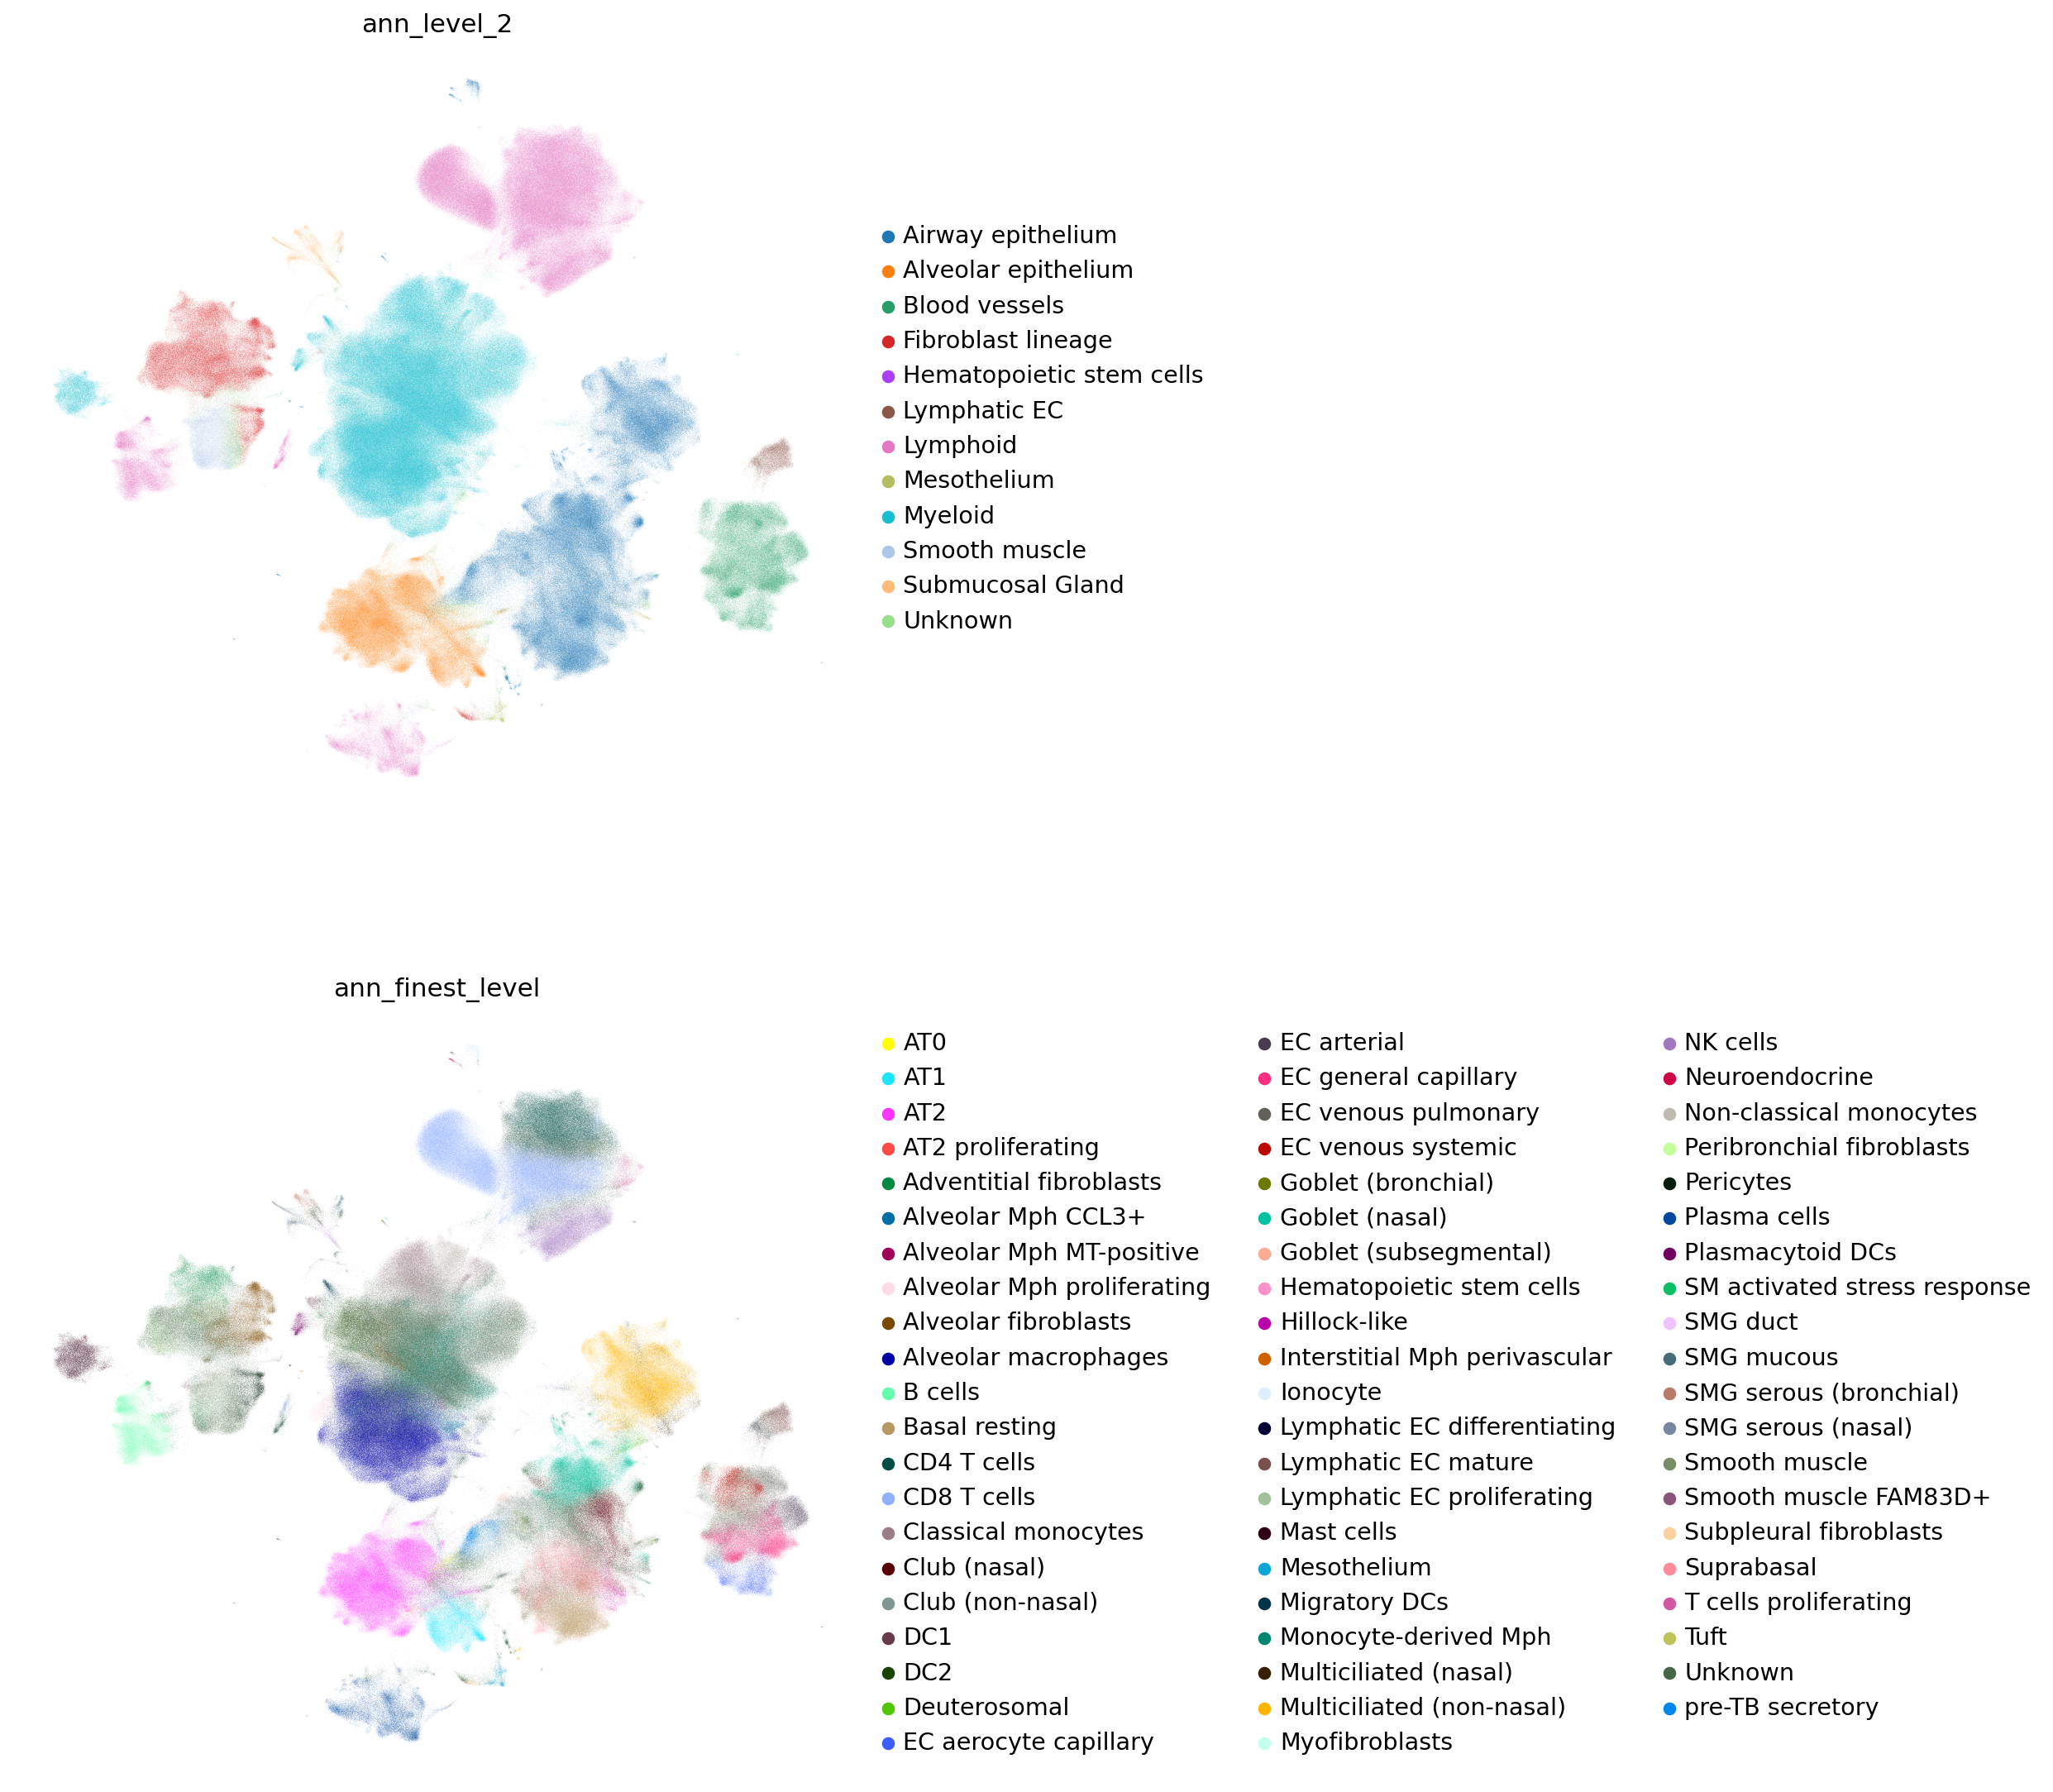

In [34]:
# as check:
sc.pl.umap(ext, color=["ann_level_2", "ann_finest_level"], ncols=1, frameon=False)

remove thresholded transfered annotations (those are now in ann_level_[1-5])

In [35]:
for lev in range(1, 6):
    del ext.obs[f"transf_ann_level_{lev}_label_thresholded"]

add ontology cell type labels for cellxgene:

In [36]:
ct_to_ontology = {
    ct: ont
    for ct, ont in zip(cell_type_to_ontology.index, cell_type_to_ontology.Uberon)
}

Check if any labels are missing from our mapping:

In [37]:
for ct in ext.obs.ann_finest_level.unique():
    if ct not in ct_to_ontology.keys():
        print(ct)

Unknown


Now perform mapping:

In [38]:
ext.obs["cell_type"] = ext.obs.ann_finest_level.map(ct_to_ontology)

Rename single cell assays according to ontology standards:

In [39]:
scp_mapping = {
    "10X 3'": "10x 3' transcription profiling",
    "10X 3' v1": "10x 3' v1",
    "10X 3' v2": "10x 3' v2",
    "10X 3' v3": "10x 3' v3",
    "10X 5'": "10x 5' transcription profiling",
    "10X 5' v1": "10x 5' v1",
    "10X 5' v2": "10x 5' v2",
    "Drop-Seq": "Drop-seq",
    "Seq-Well": "Seq-Well",
}

In [40]:
ext.obs.assay = ext.obs.assay.map(scp_mapping)

Map ages to cellxgene ontology standards:

In [41]:
ages = ext.obs.age_or_mean_of_age_range.unique()

In [42]:
age_to_devstage = dict()
for age in ages:
    if age < 0:
        raise ValueError(
            "There is a subject with age below 0, need to generate a proper encoding for that!"
        )
    elif age <= 1 / 12:
        age_to_devstage[age] = "newborn human stage"  # from 0 - 1 month
    elif age <= 1:
        age_to_devstage[age] = str(round(age * 12)) + "-month-old human stage"
    elif age > 1:
        age_to_devstage[age] = str(round(age)) + "-year-old human stage"

In [43]:
ext.obs["development_stage"] = ext.obs.age_or_mean_of_age_range.map(age_to_devstage)

In [44]:
ext.obs.development_stage.fillna("unknown", inplace=True)

Check which age ranges are in the atlas:

In [21]:
sorted((ext.obs.age_range.unique().dropna()))

['30-35', '40-45', '50-55', '55-60', '60-65', '65-70', 'nan']

In [22]:
age_range_to_devstage = {
    "30-35": "4th decade",
    "40-45": "5th decade",
    "50-55": "6th decade",
    "55-60": "6th decade",
    "60-65": "7th decade",
    "65-70": "7th decade",
}

In [23]:
cells_with_age_ranges_ext = ext.obs.index[ext.obs.age_range.str.contains("-")]

In [24]:
len(cells_with_age_ranges_ext)

118187

In [27]:
ext.obs.development_stage = (
    ext.obs.development_stage.tolist()
)  # to enable addition of new categories

In [28]:
ext.obs.loc[cells_with_age_ranges_ext, "development_stage"] = ext.obs.loc[
    cells_with_age_ranges_ext, "age_range"
].map(age_range_to_devstage)

Map diseases to cellxgene ontology:

In [46]:
disease_to_ontology = {
    "CF": "cystic fibrosis",  # MONDO:0009061
    "COPD": "chronic obstructive pulmonary disease",  # MONDO:0005002,
    "COVID-19": "COVID-19",  # MONDO:0100096
    "COVID-19 moderate": "COVID-19",  # MONDO:0100096
    "COVID-19 severe": "COVID-19",  # MONDO:0100096
    "Chronic rhinitis": "chronic rhinitis",  # MONDO:0004514
    "End-stage lung fibrosis, unknown etiology": "pulmonary fibrosis",  # MONDO:0002771
    "HP": "hypersensitivity pneumonitis",  # MONDO:0017853
    "Healthy": "normal",  # "PATO:0000461
    "Healthy (tumor adjacent)": "normal",  # "PATO:0000461
    "ILD": "interstitial lung disease",  # MONDO:0015925
    "IPF": "pulmonary fibrosis",  # MONDO:0002771
    "Large Cell Carcinoma": "lung large cell carcinoma",  # MONDO:0003050
    "Lung adenocarcinoma": "lung adenocarcinoma",  # MONDO:0005061
    "Lymphangioleiomyomatosis": "lymphangioleiomyomatosis",  # MONDO:0011705
    "Myositis-associated ILD": "interstitial lung disease",  # MONDO:0015925 # UNCLEAR IF THIS SHOULD BE MYOSITIS
    "NSIP": "non-specific interstitial pneumonia",  # MONDO:0019622
    "Pleiomorphic Carcinoma": "pleomorphic carcinoma",  # MONDO:0003573
    "Pneumonia non-COVID": "pneumonia",  # MONDO:0005249
    "Sarcoidosis": "pulmonary sarcoidosis",  # MONDO:0001708
    "Squamous Cell Carcinoma": "squamous cell lung carcinoma",  # MONDO:0005097
    "Systemic sclerosis-associated ILD": "interstitial lung disease",  # MONDO:0015925 # UNCLEAR IF THIS SHOULD BE SYSTEMIC SCLEROSIS
    "anti-CD3 anti-CD28 antibody stimulated": "nan",
}

In [47]:
ext.obs["disease"] = ext.obs.lung_condition.map(disease_to_ontology)

Rename suspension categories according to cellxgene standards:

In [48]:
susp_type_mapper = {"cells": "cell", "nuclei": "nucleus"}

In [49]:
ext.obs.suspension_type = ext.obs.suspension_type.map(susp_type_mapper)

In [20]:
ext.obs.suspension_type.unique()

['cell', 'nucleus']
Categories (2, object): ['cell', 'nucleus']

sort columns alphabetically:

In [51]:
ext.obs = ext.obs.loc[:, sorted(ext.obs.columns)].copy()

In [52]:
ext

AnnData object with n_obs × n_vars = 2382658 × 59586
    obs: "3'_or_5'", 'BMI', 'age', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_level_1_uncert', 'tra

Convert float64 to float32 for counts if not done yet (both raw and normalized):

In [53]:
ext.X

<2382658x59586 sparse matrix of type '<class 'numpy.float32'>'
	with 4333222727 stored elements in Compressed Sparse Row format>

In [54]:
ext.layers["counts"]

<2382658x59586 sparse matrix of type '<class 'numpy.float32'>'
	with 4312860970 stored elements in Compressed Sparse Row format>

In [55]:
ext.layers["soupX"]

<2382658x59586 sparse matrix of type '<class 'numpy.float32'>'
	with 187231837 stored elements in Compressed Sparse Row format>

In [56]:
# ext.X = ext.X.astype(np.float32)

Set all versions of nan (i.e. "nan", NaN, None, etc.) to np.nan:

In [42]:
ext_obs_none_entries = ext.obs.applymap(utils.check_if_nan)
ext.obs.mask(ext_obs_none_entries.values, inplace=True)

Convert categorical annotation np.nans to "nan"s (strings) for cellxgene:

In [43]:
for cellxgene_cat in [
    "assay",
    "development_stage",
    "disease",
    "tissue",
    "sex",
    "sample",
    "cell_type",
    "ancestry",
    "donor_id",
    "suspension_type",
    "age_range",
]:
    print(
        f"Number of nans/Nones for {cellxgene_cat}: {pd.isnull(ext.obs[cellxgene_cat]).sum()}. Setting to 'nan' (string)."
    )
    ext.obs[cellxgene_cat] = ext.obs[cellxgene_cat].tolist()
    ext.obs.loc[pd.isnull(ext.obs[cellxgene_cat]), cellxgene_cat] = "nan"
    ext.obs[cellxgene_cat] = pd.Categorical(ext.obs[cellxgene_cat])

Number of nans/Nones for assay: 0. Setting to 'nan' (string).
Number of nans/Nones for development_stage: 0. Setting to 'nan' (string).
Number of nans/Nones for disease: 4384. Setting to 'nan' (string).
Number of nans/Nones for tissue: 1643599. Setting to 'nan' (string).
Number of nans/Nones for sex: 970836. Setting to 'nan' (string).
Number of nans/Nones for sample: 0. Setting to 'nan' (string).
Number of nans/Nones for cell_type: 623313. Setting to 'nan' (string).
Number of nans/Nones for ancestry: 1433874. Setting to 'nan' (string).
Number of nans/Nones for donor_id: 0. Setting to 'nan' (string).
Number of nans/Nones for suspension_type: 0. Setting to 'nan' (string).
Number of nans/Nones for age_range: 2164260. Setting to 'nan' (string).


Check which genes have no ensembl ID (these are e.g. genes that didn't exist anymore in the ensembl version we mapped to, or viral genes, or micro-RNAs). Set their ensembl ID to the gene names.

In [59]:
ext.var.head(5)

,original_aggr,ensembl_id
1-DEC,1-DEC,NaN
A1BG,A1BG,ENSG00000121410.12
A1BG-AS1,A1BG-AS1,ENSG00000268895.6
A1CF,A1CF,ENSG00000148584.15
A2M,A2M,ENSG00000175899.15


In [60]:
ext.var.rename(columns={"original_aggr": "original_gene_symbols"}, inplace=True)

In [61]:
ext.var["gene_symbol"] = ext.var.index

In [62]:
print(
    f"Number of nans/Nones for ensembl IDs: {pd.isnull(ext.var.ensembl_id).sum()}. Setting to gene names instead."
)
ext.var.ensembl_id = (
    ext.var.ensembl_id.tolist()
)  # so that we can add new names, this is not possible with a categorical
ext.var.loc[pd.isnull(ext.var.ensembl_id), "ensembl_id"] = ext.var.loc[
    pd.isnull(ext.var.ensembl_id), "gene_symbol"
]

Number of nans/Nones for ensembl IDs: 2489. Setting to gene names instead.


Remove suffices from ensembl IDs (ensembl ID versions are not used in cellxgene)

In [63]:
ext.var["ensembl_id_geneversion"] = ext.var.ensembl_id.copy()

In [64]:
ext.var["ensembl_id"] = [
    x.split(".")[0] if x.startswith("ENS") else x
    for x in ext.var.ensembl_id_geneversion
]

Check if ensembl ids are still unique:

In [65]:
ext.n_vars

59586

In [66]:
len(set(ext.var.ensembl_id)) == ext.n_vars

True

Define schema version and title for cellxgene:

In [67]:
ext.uns["schema_version"] = "3.0.0"
ext.uns["title"] = "Human_Lung_Cell_Atlas_full"

Set var index to ensembl_ids

In [68]:
ext.var.index = ext.var.ensembl_id

Check if ensembl_ids are unique:

In [69]:
ext.n_vars == len(set(ext.var.index))

True

Remove Barbry_unpubl from data as its mapping was unsuccessful and the dataset is likely to corrupt downstream analyses for people who are unaware:

In [70]:
ext = ext[ext.obs.study != "Barbry_unpubl", :].copy()

shuffle cell order for plotting:

In [8]:
shuffled_index = random.sample(ext.obs.index.tolist(), k=ext.n_obs)

In [9]:
ext = ext[shuffled_index, :].copy()

Recalculate neighbor graph and umap:

In [6]:
sc.pp.neighbors(ext, use_rep="X_scanvi_emb", n_neighbors=30)

In [ ]:
sc.tl.umap(ext)

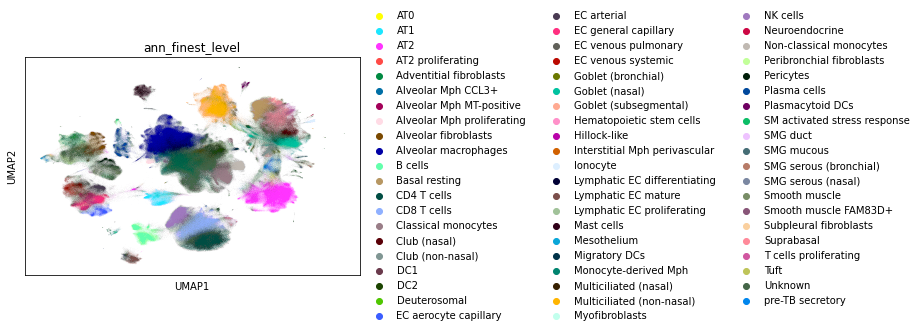

In [33]:
sc.pl.umap(ext, color=["ann_finest_level"])

Write:

In [30]:
ext

AnnData object with n_obs × n_vars = 2282447 × 59586
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_

In [31]:
ext.shape

(2282447, 59586)

In [44]:
ext.write(path_hlca_ext_clean_out)  # , compression="gzip")

In [4]:
# ext = sc.read_h5ad(path_hlca_ext_clean_out)

## Store tables:

In [63]:
dataset_overview.to_csv(
    os.path.join(dir_supp_tables_out, "SuppT_1_dataset_overview.csv")
)

In [64]:
sample_overview.to_csv(os.path.join(dir_supp_tables_out, "SuppT_2_sample_overview.csv"))

In [26]:
manual_ann_hierarchy.to_csv(os.path.join(dir_supp_tables_out, "SuppT_5_manual_ann.csv"))

In [66]:
harmonizing_df.to_csv(
    os.path.join(dir_supp_tables_out, "SuppT_4_celltype_ref_mapping.csv")
)

In [68]:
# for ct, ct_res in ct_results_gene.items():
#     ct_res.to_csv(
#         os.path.join(
#             dir_supp_tables_out, "SuppT_X_covariate_modeling_gene_results", ct + ".csv"
#         )
#     )